In [1]:
#!ls -al /content/drive/MyDrive/lab4
!nvidia-smi

Fri May 21 07:48:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torchsummary import summary

from matplotlib import pyplot as plt
from scipy.io import loadmat
import math, sys, os, time
import pandas as pd
import numpy as np

DATASET_DIR = "/content/drive/MyDrive/AE-4-EEG-Artifact-Removal/BCICIV2a/"
BASE_DIR = "/content/drive/MyDrive/lab4/"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# torch shape: (batch_size, chan (depth), h, w)

# EEG-model

In [3]:
class EEGNet(nn.Module):
    def __init__(self):
        super(EEGNet, self).__init__()

        self.F1 = 8
        self.F2 = 16
        self.D = 2

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, self.F1, (1, 64), padding=(0, 32), bias=False),
            nn.BatchNorm2d(self.F1)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(self.F1, self.D*self.F1, (22, 1), groups=self.F1, bias=False),
            nn.BatchNorm2d(self.D*self.F1),
            nn.ELU(),
            nn.AvgPool2d((1, 4)),
            nn.Dropout(0.5)
        )

        self.Conv3 = nn.Sequential(
            nn.Conv2d(self.D*self.F1, self.D*self.F1, (1, 16), padding=(0, 8), groups=self.D*self.F1, bias=False),
            nn.Conv2d(self.D*self.F1, self.F2, (1, 1), bias=False),
            nn.BatchNorm2d(self.F2),
            nn.ELU(),
            nn.AvgPool2d((1, 8)),
            nn.Dropout(0.5)
        )

        self.classifier = nn.Linear(16*17, 4, bias=True)
        #self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.Conv3(x)
        
        x = x.view(-1, 16*17)
        x = self.classifier(x)
        #x = self.softmax(x)
        return x

In [4]:
class ShallowConvNet(nn.Module):
    def __init__(self):
        super(ShallowConvNet, self).__init__()

        self.conv1 = nn.Conv2d(1, 40, (1, 13), bias=False)
        self.conv2 = nn.Conv2d(40, 40, (22, 1), bias=False)
        self.Bn1   = nn.BatchNorm2d(40)
        # self.SquareLayer = square_layer()
        self.AvgPool1 = nn.AvgPool2d((1, 35), stride=(1, 7))
        # self.LogLayer = Log_layer()
        self.Drop1 = nn.Dropout(0.25)
        self.classifier = nn.Linear(40*74, 4, bias=True)
        #self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.Bn1(x)
        x = x ** 2
        x = self.AvgPool1(x)
        x = torch.log(x)
        x = self.Drop1(x)
        x = x.view(-1, 40*74)
        x = self.classifier(x)

        #x = self.softmax(x)
        return x

In [5]:
class SCCNet(nn.Module):
    def __init__(self):
        super(SCCNet, self).__init__()
        # bs, 1, channel, sample
        self.conv1 = nn.Conv2d(1, 22, (22, 1))
        self.Bn1 = nn.BatchNorm2d(22)
        # bs, 22, 1, sample
        self.conv2 = nn.Conv2d(22, 20, (1, 12), padding=(0, 6))
        self.Bn2   = nn.BatchNorm2d(20)
        # self.SquareLayer = square_layer()
        self.Drop1 = nn.Dropout(0.5)
        self.AvgPool1 = nn.AvgPool2d((1, 62), stride=(1, 12))
        self.classifier = nn.Linear(840, 4, bias=True)
        #self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.conv1(x)
        x = self.Bn1(x)
        x = self.conv2(x)
        x = self.Bn2(x)
        x = x ** 2
        x = self.Drop1(x)
        x = self.AvgPool1(x)
        x = torch.log(x)
        x = x.view(-1, 840)
        x = self.classifier(x)

        #x = self.softmax(x)
        return x

In [6]:
class TSception(nn.Module):
    def conv_block(self, in_chan, out_chan, kernel, step, pool):
        return nn.Sequential(
            nn.Conv2d(in_channels=in_chan, out_channels=out_chan,
                      kernel_size=kernel, stride=step, padding=0),
            nn.LeakyReLU(),
            nn.AvgPool2d(kernel_size=(1, pool), stride=(1, pool)))

    def __init__(self, num_classes, input_size, sampling_rate, num_T, num_S, hidden, dropout_rate):
        # input_size: 1 x EEG channel x datapoint
        super(TSception, self).__init__()
        self.inception_window = [0.5, 0.25, 0.125]
        self.pool = 8
        # by setting the convolutional kernel being (1,lenght) and the strids being 1 we can use conv2d to
        # achieve the 1d convolution operation
        self.Tception1 = self.conv_block(1, num_T, (1, int(self.inception_window[0] * sampling_rate)), 1, self.pool)
        self.Tception2 = self.conv_block(1, num_T, (1, int(self.inception_window[1] * sampling_rate)), 1, self.pool)
        self.Tception3 = self.conv_block(1, num_T, (1, int(self.inception_window[2] * sampling_rate)), 1, self.pool)

        self.Sception1 = self.conv_block(num_T, num_S, (int(input_size[1]), 1), 1, int(self.pool*0.25))
        self.Sception2 = self.conv_block(num_T, num_S, (int(input_size[1] * 0.5), 1), (int(input_size[1] * 0.5), 1),
                                         int(self.pool*0.25))
        self.fusion_layer = self.conv_block(num_S, num_S, (3, 1), 1, 2)
        self.BN_t = nn.BatchNorm2d(num_T)
        self.BN_s = nn.BatchNorm2d(num_S)
        self.BN_fusion = nn.BatchNorm2d(num_S)

        size = self.get_size(input_size)
        self.fc = nn.Sequential(
            nn.Linear(size[1], hidden),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden, num_classes),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        y = self.Tception1(x)
        out = y
        y = self.Tception2(x)
        out = torch.cat((out, y), dim=-1)
        y = self.Tception3(x)
        out = torch.cat((out, y), dim=-1)
        out = self.BN_t(out)
        z = self.Sception1(out)
        out_ = z
        z = self.Sception2(out)
        out_ = torch.cat((out_, z), dim=2)

        out = self.BN_s(out_)
        out = self.fusion_layer(out)
        out = self.BN_fusion(out)
        out = out.view(out.size()[0], -1)
        out = self.fc(out)
        return out

    def get_size(self, input_size):
        # here we use an array with the shape being
        # (1(mini-batch),1(convolutional channel),EEG channel,time data point)
        # to simulate the input data and get the output size
        data = torch.ones((1, input_size[0], input_size[1], int(input_size[2])))
        y = self.Tception1(data)
        out = y
        y = self.Tception2(data)
        out = torch.cat((out, y), dim=-1)
        y = self.Tception3(data)
        out = torch.cat((out, y), dim=-1)
        out = self.BN_t(out)
        z = self.Sception1(out)
        out_final = z
        z = self.Sception2(out)
        out_final = torch.cat((out_final, z), dim=2)
        out = self.BN_s(out_final)
        out = self.fusion_layer(out)
        out = self.BN_fusion(out)
        out = out.view(out.size()[0], -1)
        return out.size()

# Model Utilities & some function

In [7]:
class Model(object):
    def __init__(self, model=None, lr=0.001):
        super(Model, self).__init__()
        self.model = model
        self.losses = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(model.parameters(), lr=lr)
    def fit(self, trainloader=None, validloader=None, epochs=1, monitor=None, verbose=1):
        doValid = False if validloader == None else True
        pre_ck_point = [float("inf"), 0.0, float("inf"), 0.0, 0] # loss, acc, val_loss, val_acc, epoch
        history = {"loss": [], "acc": [], "val_loss": [], "val_acc": []}
        for ep in range(1, epochs + 1):
            proc_start = time.time() # timer start
            if ((not (ep % 10)) or (ep == 1)) and verbose != 0:
                print(f"Epoch {ep}/{epochs}")
            self.model.train()
            step = 1
            for x_batch, y_batch in trainloader:
                x_batch, y_batch = x_batch.to(device, dtype=torch.float), y_batch.to(device)
                pred = self.model(x_batch)
                loss = self.losses(pred, y_batch)
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()

                if ((not (ep % 10)) or (ep == 1)) and verbose != 0:
                    pbar = int(step * 30 / len(trainloader))
                    print("\r{}/{} [{}{}]".format(
                        step, len(trainloader), ">" * pbar, " " * (30 - pbar)), 
                        end="")
                step += 1
            # evaluate
            loss, acc = self.evaluate(trainloader)
            val_loss, val_acc = self.evaluate(validloader) if doValid else (0, 0)
            history["loss"] = np.append(history["loss"], loss)
            history["acc"] = np.append(history["acc"], acc)
            history["val_loss"] = np.append(history["val_loss"], val_loss)
            history["val_acc"] = np.append(history["val_acc"], val_acc)
            # dump message
            if ((not (ep % 10)) or (ep == 1)) and verbose != 0:
                print(" {:.4f}s - loss: {:.4f} - acc: {:.4f} - val_loss: {:.4f} - val_acc: {:.4f}".format(
                    time.time()-proc_start, history["loss"][-1], 
                    history["acc"][-1], history["val_loss"][-1], history["val_acc"][-1])
                )
            # model check point
            if self.__updateCheckpoint(monitor, pre_ck_point, [loss, acc, val_loss, val_acc, ep]):
                if not os.path.exists("./model"):
                    os.mkdir("./model")
                model_name = f"model/checkpoint_model_ep-{ep}.pt"
                self.save(model_name)
                history["lastest_model_path"] = model_name
                pre_ck_point = [loss, acc, val_loss, val_acc, ep]
        return history
    def evaluate(self, dataloader):
        total, acc = 0, 0
        self.model.eval()
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device, dtype=torch.float), y_batch.to(device)
            pred = self.model(x_batch)
            loss = self.losses(pred, y_batch).item()
            total += y_batch.shape[0]
            acc += (torch.sum(pred.argmax(dim=1)==y_batch)).item()
        acc /= total

        return (loss, acc)
    def predict(self, dataset, batch_size=128):
        dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False)
        prediction = []
        self.model.eval()
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device, dtype=torch.float), y_batch.to(device)
            pred = self.model(x_batch).cpu()
            prediction = np.append(prediction, pred.argmax(dim=1).numpy())
        return prediction.astype("uint8")
    def save(self, filepath):
        torch.save(self.model, filepath)
    @classmethod
    def load(cls, filepath):
        return cls(torch.load(filepath))
    def __updateCheckpoint(self, monitor, pre_ck_point, evaluation):
        if type(monitor) is int:
            return True if evaluation[4] % monitor == 0 else False
        elif type(monitor) is list:
            for _ in monitor:
                if not _ in ["loss", "acc", "val_loss", "val_acc"]:
                    raise Exception(f"\"{_}\" is not a valid monitor condition.")
                elif _ == "loss" and pre_ck_point[0] <= evaluation[0]:
                    return False # present epoch loss > history loss
                elif _ == "acc" and pre_ck_point[1] >= evaluation[1]:
                    return False # present epoch acc < history acc
                elif _ == "val_loss" and pre_ck_point[2] <= evaluation[2]:
                    return False # present epoch val_loss > history val_loss
                elif _ == "val_acc" and pre_ck_point[3] >= evaluation[3]:
                    return False # present epoch val_acc < history val_acc        
        return True

In [8]:
def plot_confusion_matrix(conf_matrix, title="Confusion Matrix"):
    plt.figure(figsize=(10, 10))
    plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    plt.xticks([0,1,2,3], [0,1,2,3], rotation=45)
    plt.yticks([0,1,2,3], [0,1,2,3])

    thresh = conf_matrix.max() / 2.
    for i in range(4):
        for j in range(4):
            plt.text(j, i, format(conf_matrix[i, j], "d"), 
                horizontalalignment="center", color="white" if conf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel("Real label")
    plt.xlabel("Pred label")
    plt.show()

#Part 1

## Problem 1

In [ ]:
BATCH_SIZE = 32
Learning_Rate = 0.001
EPOCHS = 500

In [ ]:
train_raw = loadmat(DATASET_DIR + "BCIC_S01_T.mat")
test_raw = loadmat(DATASET_DIR + "BCIC_S01_E.mat")
trX, trY, teX, teY = train_raw["x_train"], train_raw["y_train"], test_raw["x_test"], test_raw["y_test"]

In [ ]:
x_train = torch.from_numpy(np.expand_dims(trX, axis=1))
y_train = torch.from_numpy(np.reshape(trY, (trY.size, ))).long()
x_test = torch.from_numpy(np.expand_dims(teX, axis=1))
y_test = torch.from_numpy(np.reshape(teY, (teY.size, ))).long()

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
trainset, testset = TensorDataset(x_train, y_train), TensorDataset(x_test, y_test)

""" create dataloader """
trainloader = DataLoader(dataset=trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(dataset=testset, batch_size=BATCH_SIZE, shuffle=True)

torch.Size([288, 1, 22, 562]) torch.Size([288])
torch.Size([288, 1, 22, 562]) torch.Size([288])


Epoch 1/500
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.2119s - loss: 1.3791 - acc: 0.2812 - val_loss: 1.3910 - val_acc: 0.2500
Epoch 10/500
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.2036s - loss: 0.9965 - acc: 0.5799 - val_loss: 1.0180 - val_acc: 0.4757
Epoch 20/500
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.2027s - loss: 0.7497 - acc: 0.6840 - val_loss: 0.9513 - val_acc: 0.5660
Epoch 30/500
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.2123s - loss: 0.6505 - acc: 0.7535 - val_loss: 0.7895 - val_acc: 0.6319
Epoch 40/500
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.1955s - loss: 0.6266 - acc: 0.8160 - val_loss: 0.7247 - val_acc: 0.6667
Epoch 50/500
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.1968s - loss: 0.3396 - acc: 0.8472 - val_loss: 0.5205 - val_acc: 0.6806
Epoch 60/500
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.2068s - loss: 0.3886 - acc: 0.8715 - val_loss: 0.4691 - val_acc: 0.7292
Epoch 70/500
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.2025s - loss: 0.3164 - acc: 0.8785 - val_loss: 0.5561 - val_acc: 0.7361
Epoch 80/

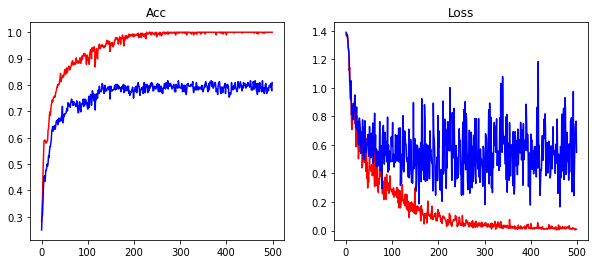

In [ ]:
eegnet = EEGNet().to(device)
#summary(eegnet, (1, 22, 562))
model = Model(eegnet, lr=Learning_Rate)
# save checkpoint model when both trainset and validset get new max acc
history = model.fit(trainloader=trainloader, validloader=testloader, epochs=EPOCHS, monitor=["acc", "val_acc"])

plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
plt.title("Acc")
plt.plot(history["acc"], color="red")
plt.plot(history["val_acc"], color="blue")
plt.subplot(1, 2, 2)
plt.title("Loss")
plt.plot(history["loss"], color="red")
plt.plot(history["val_loss"], color="blue")
plt.show()

### (a)

In [ ]:
# load model
ld_model = Model.load(history["lastest_model_path"])
eva_train = ld_model.evaluate(dataloader=trainloader)
print(f"Train Accuracy: {eva_train[1]:.4f}\tTrain Loss: {eva_train[0]:.4f}")
eva_test = ld_model.evaluate(dataloader=testloader)
print(f"Test Accuracy: {eva_test[1]:.4f}\tTest Loss: {eva_test[0]:.4f}")

Train Accuracy: 1.0000	Train Loss: 0.0111
Test Accuracy: 0.8160	Test Loss: 1.2120


### (b)

In [ ]:
rec_train = {"total": [0, 0, 0, 0], "hit": [0, 0, 0, 0]}
rec_test = {"total": [0, 0, 0, 0], "hit": [0, 0, 0, 0]}
# confusion matrix in (c)
conf_matrix_train = np.zeros(shape=(4, 4), dtype="uint8")
conf_matrix_test = np.zeros(shape=(4, 4), dtype="uint8")

real_train = trY.reshape(trY.size)
real_test = teY.reshape(teY.size)
pred_train = ld_model.predict(dataset=trainset)
pred_test = ld_model.predict(dataset=testset)

for i in range(288):
    rec_train["total"][real_train[i]] += 1
    rec_train["hit"][real_train[i]] += (1 if real_train[i] == pred_train[i] else 0)
    rec_test["total"][real_test[i]] += 1
    rec_test["hit"][real_test[i]] += (1 if real_test[i] == pred_test[i] else 0)

    conf_matrix_train[real_train[i]][pred_train[i]] += 1
    conf_matrix_test[real_test[i]][pred_test[i]] += 1

In [ ]:
for i in range(4):
    print("Train accuracy of class-{}: {}".format(i, rec_train["hit"][i] / rec_train["total"][i]))
print()
for i in range(4):
    print("Test accuracy of class-{}: {}".format(i, rec_test["hit"][i] / rec_test["total"][i]))

Train accuracy of class-0: 1.0
Train accuracy of class-1: 1.0
Train accuracy of class-2: 1.0
Train accuracy of class-3: 1.0

Test accuracy of class-0: 0.8194444444444444
Test accuracy of class-1: 0.9861111111111112
Test accuracy of class-2: 0.7638888888888888
Test accuracy of class-3: 0.6944444444444444


### (c)

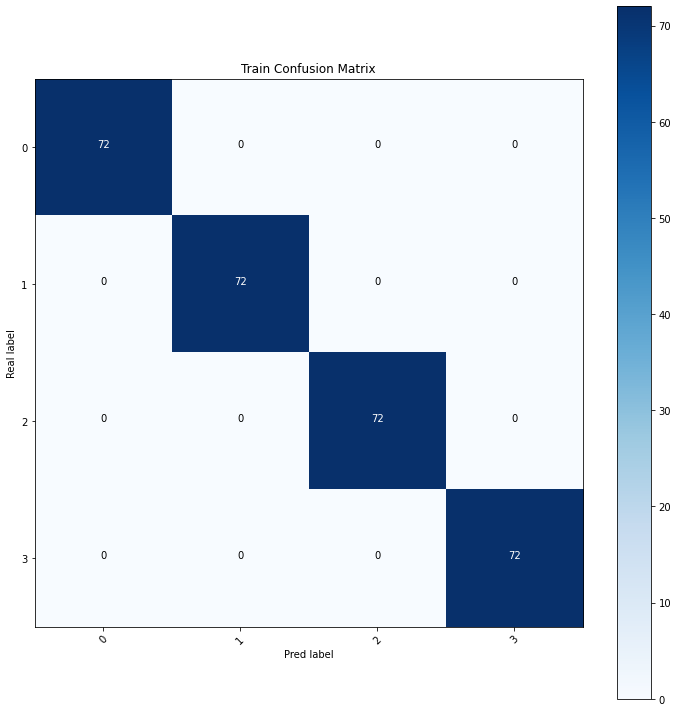

In [ ]:
#print(conf_matrix_train)
plot_confusion_matrix(conf_matrix_train, "Train Confusion Matrix")

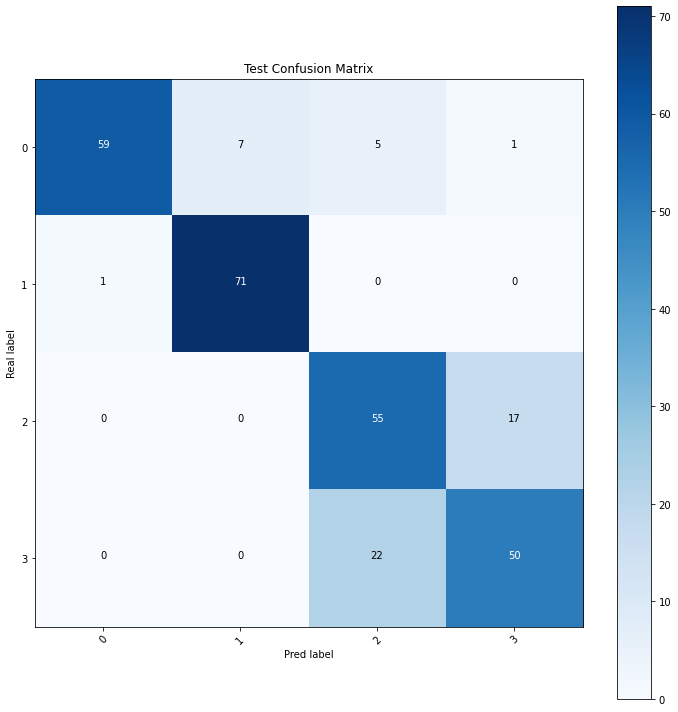

In [ ]:
#print(conf_matrix_test)
plot_confusion_matrix(conf_matrix_test, "Test Confusion Matrix")

## Problem 2

In [ ]:
train_raw = loadmat(DATASET_DIR + "BCIC_S01_T.mat")
test_raw = loadmat(DATASET_DIR + "BCIC_S01_E.mat")
trX, trY, teX, teY = train_raw["x_train"], train_raw["y_train"], test_raw["x_test"], test_raw["y_test"]
x_train = torch.from_numpy(np.expand_dims(trX, axis=1))
y_train = torch.from_numpy(np.reshape(trY, (trY.size, ))).long()
x_test = torch.from_numpy(np.expand_dims(teX, axis=1))
y_test = torch.from_numpy(np.reshape(teY, (teY.size, ))).long()
trainset, testset = TensorDataset(x_train, y_train), TensorDataset(x_test, y_test)

In [ ]:
eegnet = EEGNet().to(device)
#ld_models = {}
for lr in [0.003, 0.001, 0.0003, 0.0001]:
    #best_models = {}
    for bs in [64, 32, 8, 2]:
        print(f"Process at learninr rate: {lr}, batch size: {bs}")
        trainloader = DataLoader(dataset=trainset, batch_size=bs, shuffle=True)
        testloader = DataLoader(dataset=testset, batch_size=bs, shuffle=True)
        model = Model(eegnet, lr=lr)
        history = model.fit(trainloader=trainloader, validloader=testloader, 
            epochs=500, monitor=["acc", "val_acc"], verbose=0)
        best_model = Model.load(history["lastest_model_path"])
        best_model.save(f"/content/drive/MyDrive/lab4/model/bs-{bs}_lr-{lr}_model.pt")
        #best_models[bs] = Model.load(history["lastest_model_path"])
    #ld_models[lr] = best_models

Process at learninr rate: 0.003, batch size: 64
Process at learninr rate: 0.003, batch size: 32
Process at learninr rate: 0.003, batch size: 8
Process at learninr rate: 0.003, batch size: 2
Process at learninr rate: 0.001, batch size: 64
Process at learninr rate: 0.001, batch size: 32
Process at learninr rate: 0.001, batch size: 8
Process at learninr rate: 0.001, batch size: 2
Process at learninr rate: 0.0003, batch size: 64
Process at learninr rate: 0.0003, batch size: 32
Process at learninr rate: 0.0003, batch size: 8
Process at learninr rate: 0.0003, batch size: 2
Process at learninr rate: 0.0001, batch size: 64
Process at learninr rate: 0.0001, batch size: 32
Process at learninr rate: 0.0001, batch size: 8
Process at learninr rate: 0.0001, batch size: 2


In [ ]:
for lr in [0.003, 0.001, 0.0003, 0.0001]:
    for bs in [64, 32, 8, 2]:
        ld_model = Model.load(f"/content/drive/MyDrive/lab4/model/bs-{bs}_lr-{lr}_model.pt")
        testloader = DataLoader(dataset=testset, batch_size=bs, shuffle=True)
        eva_test = ld_model.evaluate(dataloader=testloader)
        print(f"Test Accuracy of lr={lr}, batch_size={bs}: {eva_test[1]:.4f}")

Test Accuracy of lr=0.003, batch_size=64: 0.8507
Test Accuracy of lr=0.003, batch_size=32: 0.8472
Test Accuracy of lr=0.003, batch_size=8: 0.8507
Test Accuracy of lr=0.003, batch_size=2: 0.7951
Test Accuracy of lr=0.001, batch_size=64: 0.8194
Test Accuracy of lr=0.001, batch_size=32: 0.8403
Test Accuracy of lr=0.001, batch_size=8: 0.8507
Test Accuracy of lr=0.001, batch_size=2: 0.8229
Test Accuracy of lr=0.0003, batch_size=64: 0.8194
Test Accuracy of lr=0.0003, batch_size=32: 0.8333
Test Accuracy of lr=0.0003, batch_size=8: 0.8438
Test Accuracy of lr=0.0003, batch_size=2: 0.8368
Test Accuracy of lr=0.0001, batch_size=64: 0.8194
Test Accuracy of lr=0.0001, batch_size=32: 0.8194
Test Accuracy of lr=0.0001, batch_size=8: 0.8264
Test Accuracy of lr=0.0001, batch_size=2: 0.8368


## Problem 3

In [ ]:
train_raw_set = [loadmat(DATASET_DIR + f"BCIC_S0{i}_T.mat") for i in range(1, 10)]
test_raw_set = [loadmat(DATASET_DIR + f"BCIC_S0{i}_E.mat") for i in range(1, 10)]

### SI

In [ ]:
trX, trY = np.empty((0, 22, 562)), np.empty((0, 1))
teX, teY = test_raw_set[0]["x_test"], test_raw_set[0]["y_test"]
for i in range(1, 9):
    trX = np.vstack([trX, train_raw_set[i]["x_train"]])
    trX = np.vstack([trX, test_raw_set[i]["x_test"]])
    trY = np.vstack([trY, train_raw_set[i]["y_train"]])
    trY = np.vstack([trY, test_raw_set[i]["y_test"]])
#print(trX.shape, trY.shape, teX.shape, teY.shape)
x_train = torch.from_numpy(np.expand_dims(trX, axis=1))
y_train = torch.from_numpy(np.reshape(trY, (trY.size, ))).long()
x_test = torch.from_numpy(np.expand_dims(teX, axis=1))
y_test = torch.from_numpy(np.reshape(teY, (teY.size, ))).long()
trainset, testset = TensorDataset(x_train, y_train), TensorDataset(x_test, y_test)
trainloader = DataLoader(dataset=trainset, batch_size=32, shuffle=True)
testloader = DataLoader(dataset=testset, batch_size=32, shuffle=True)

Epoch 1/500
144/144 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1.2091s - loss: 1.3487 - acc: 0.3127 - val_loss: 1.3769 - val_acc: 0.2535
Epoch 10/500
144/144 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1.1347s - loss: 1.1267 - acc: 0.5037 - val_loss: 1.0268 - val_acc: 0.6181
Epoch 20/500
144/144 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1.1404s - loss: 1.1048 - acc: 0.5579 - val_loss: 0.9270 - val_acc: 0.6528
Epoch 30/500
144/144 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1.1609s - loss: 0.9132 - acc: 0.5579 - val_loss: 0.8320 - val_acc: 0.6042
Epoch 40/500
144/144 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1.1870s - loss: 1.1204 - acc: 0.5929 - val_loss: 0.8643 - val_acc: 0.6076
Epoch 50/500
144/144 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1.1304s - loss: 1.0793 - acc: 0.5651 - val_loss: 0.8454 - val_acc: 0.6007
Epoch 60/500
144/144 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1.1301s - loss: 0.8761 - acc: 0.6270 - val_loss: 0.7588 - val_acc: 0.6458
Epoch 70/500
144/144 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1.2188s - loss: 0.8043 - acc: 0.6302 - val_loss: 0.

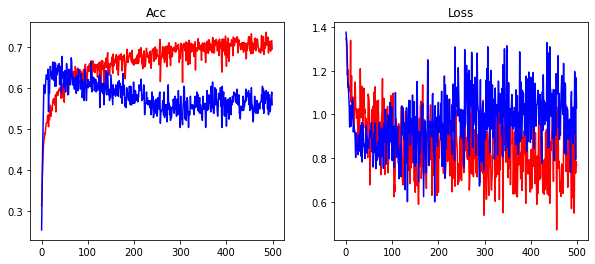

In [ ]:
model = Model(EEGNet().to(device), lr=0.001)
# save checkpoint model when both trainset and validset get new max acc
history = model.fit(trainloader=trainloader, validloader=testloader, epochs=500, monitor=["acc", "val_acc"])

plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
plt.title("Acc")
plt.plot(history["acc"], color="red")
plt.plot(history["val_acc"], color="blue")
plt.subplot(1, 2, 2)
plt.title("Loss")
plt.plot(history["loss"], color="red")
plt.plot(history["val_loss"], color="blue")
plt.show()

Test Accuracy: 0.6771	Test Loss: 0.8689
Test accuracy of class-0: 0.7638888888888888
Test accuracy of class-1: 0.9166666666666666
Test accuracy of class-2: 0.5833333333333334
Test accuracy of class-3: 0.4444444444444444


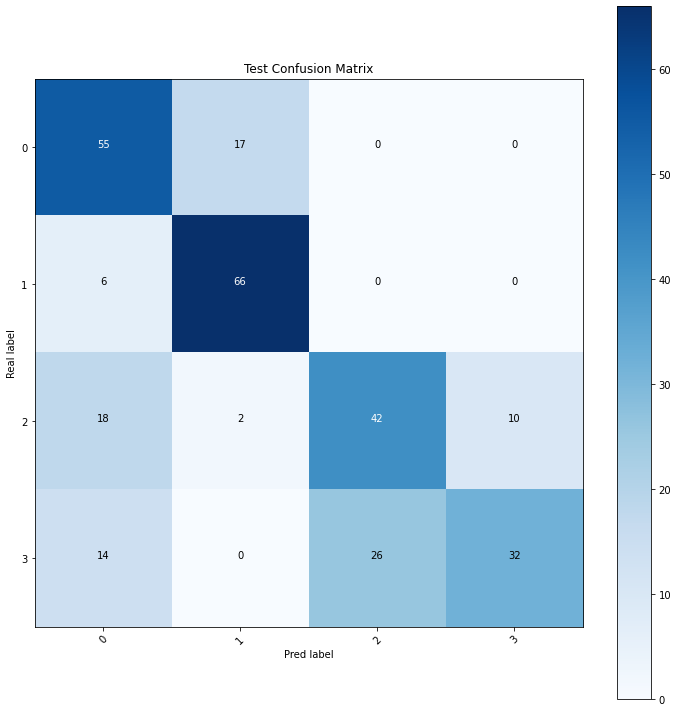

In [ ]:
# load model
ld_model = Model.load(history["lastest_model_path"])
eva_test = ld_model.evaluate(dataloader=testloader)
print(f"Test Accuracy: {eva_test[1]:.4f}\tTest Loss: {eva_test[0]:.4f}")
rec_test = {"total": [0, 0, 0, 0], "hit": [0, 0, 0, 0]}
conf_matrix_test = np.zeros(shape=(4, 4), dtype="uint8")

real_test = teY.reshape(teY.size)
pred_test = ld_model.predict(dataset=testset)
for i in range(real_test.size):
    rec_test["total"][real_test[i]] += 1
    rec_test["hit"][real_test[i]] += (1 if real_test[i] == pred_test[i] else 0)
    conf_matrix_test[real_test[i]][pred_test[i]] += 1
for i in range(4):
    print("Test accuracy of class-{}: {}".format(i, rec_test["hit"][i] / rec_test["total"][i]))
plot_confusion_matrix(conf_matrix_test, "Test Confusion Matrix")

### SD

In [ ]:
trX, trY = np.empty((0, 22, 562)), np.empty((0, 1))
teX, teY = test_raw_set[0]["x_test"], test_raw_set[0]["y_test"]
for i in range(1, 9):
    trX = np.vstack([trX, train_raw_set[i]["x_train"]])
    trX = np.vstack([trX, test_raw_set[i]["x_test"]])
    trY = np.vstack([trY, train_raw_set[i]["y_train"]])
    trY = np.vstack([trY, test_raw_set[i]["y_test"]])
trX = np.vstack([trX, train_raw_set[0]["x_train"]])
trY = np.vstack([trY, train_raw_set[0]["y_train"]])
x_train = torch.from_numpy(np.expand_dims(trX, axis=1))
y_train = torch.from_numpy(np.reshape(trY, (trY.size, ))).long()
x_test = torch.from_numpy(np.expand_dims(teX, axis=1))
y_test = torch.from_numpy(np.reshape(teY, (teY.size, ))).long()
trainset, testset = TensorDataset(x_train, y_train), TensorDataset(x_test, y_test)
trainloader = DataLoader(dataset=trainset, batch_size=32, shuffle=True)
testloader = DataLoader(dataset=testset, batch_size=32, shuffle=True)

Epoch 1/500
153/153 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1.2760s - loss: 1.3543 - acc: 0.3621 - val_loss: 1.2806 - val_acc: 0.5035
Epoch 10/500
153/153 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1.1986s - loss: 1.1246 - acc: 0.5310 - val_loss: 0.9490 - val_acc: 0.6632
Epoch 20/500
153/153 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1.1857s - loss: 1.1194 - acc: 0.5792 - val_loss: 1.0399 - val_acc: 0.6667
Epoch 30/500
153/153 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1.1805s - loss: 1.0484 - acc: 0.5856 - val_loss: 0.8030 - val_acc: 0.6771
Epoch 40/500
153/153 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1.2116s - loss: 0.8472 - acc: 0.6031 - val_loss: 0.7349 - val_acc: 0.7014
Epoch 50/500
153/153 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1.1927s - loss: 0.9229 - acc: 0.5829 - val_loss: 0.8093 - val_acc: 0.6736
Epoch 60/500
153/153 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1.1929s - loss: 0.8890 - acc: 0.6275 - val_loss: 0.7587 - val_acc: 0.6701
Epoch 70/500
153/153 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1.1810s - loss: 0.8838 - acc: 0.6428 - val_loss: 0.

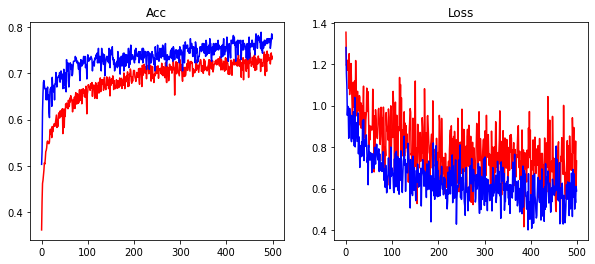

In [ ]:
model = Model(EEGNet().to(device), lr=0.001)
# save checkpoint model when both trainset and validset get new max acc
history = model.fit(trainloader=trainloader, validloader=testloader, epochs=500, monitor=["acc", "val_acc"])

plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
plt.title("Acc")
plt.plot(history["acc"], color="red")
plt.plot(history["val_acc"], color="blue")
plt.subplot(1, 2, 2)
plt.title("Loss")
plt.plot(history["loss"], color="red")
plt.plot(history["val_loss"], color="blue")
plt.show()

Test Accuracy: 0.7812	Test Loss: 0.5534
Test accuracy of class-0: 0.9027777777777778
Test accuracy of class-1: 0.8333333333333334
Test accuracy of class-2: 0.7222222222222222
Test accuracy of class-3: 0.6666666666666666


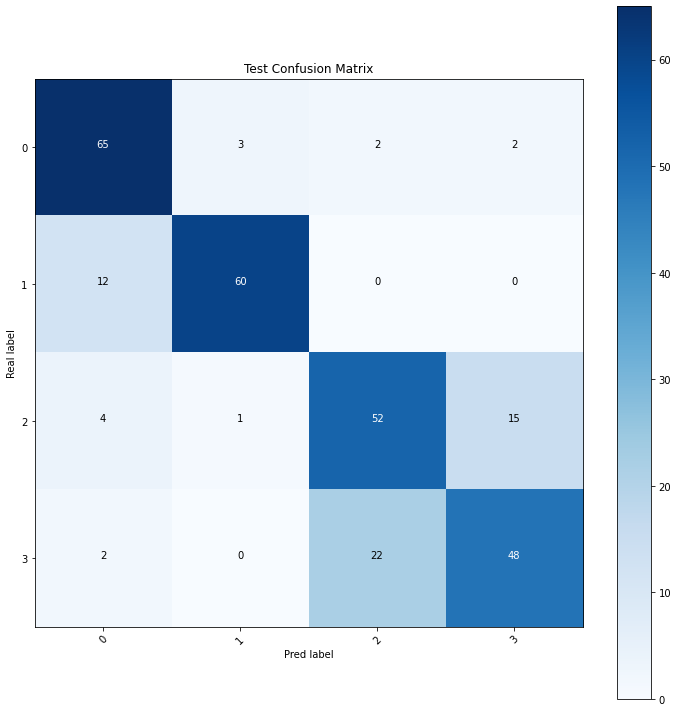

In [ ]:
# load model
ld_model = Model.load(history["lastest_model_path"])
eva_test = ld_model.evaluate(dataloader=testloader)
print(f"Test Accuracy: {eva_test[1]:.4f}\tTest Loss: {eva_test[0]:.4f}")
rec_test = {"total": [0, 0, 0, 0], "hit": [0, 0, 0, 0]}
conf_matrix_test = np.zeros(shape=(4, 4), dtype="uint8")

real_test = teY.reshape(teY.size)
pred_test = ld_model.predict(dataset=testset)
for i in range(real_test.size):
    rec_test["total"][real_test[i]] += 1
    rec_test["hit"][real_test[i]] += (1 if real_test[i] == pred_test[i] else 0)
    conf_matrix_test[real_test[i]][pred_test[i]] += 1
for i in range(4):
    print("Test accuracy of class-{}: {}".format(i, rec_test["hit"][i] / rec_test["total"][i]))
plot_confusion_matrix(conf_matrix_test, "Test Confusion Matrix")

### SI + FT

In [ ]:
trX, trY = np.empty((0, 22, 562)), np.empty((0, 1))
teX, teY = test_raw_set[0]["x_test"], test_raw_set[0]["y_test"]
for i in range(1, 9):
    trX = np.vstack([trX, train_raw_set[i]["x_train"]])
    trX = np.vstack([trX, test_raw_set[i]["x_test"]])
    trY = np.vstack([trY, train_raw_set[i]["y_train"]])
    trY = np.vstack([trY, test_raw_set[i]["y_test"]])
#print(trX.shape, trY.shape, teX.shape, teY.shape)
x_train = torch.from_numpy(np.expand_dims(trX, axis=1))
y_train = torch.from_numpy(np.reshape(trY, (trY.size, ))).long()
x_test = torch.from_numpy(np.expand_dims(teX, axis=1))
y_test = torch.from_numpy(np.reshape(teY, (teY.size, ))).long()
trainset, testset = TensorDataset(x_train, y_train), TensorDataset(x_test, y_test)
trainloader = DataLoader(dataset=trainset, batch_size=32, shuffle=True)
testloader = DataLoader(dataset=testset, batch_size=32, shuffle=True)

In [ ]:
model = Model(EEGNet().to(device), lr=0.001)
# save checkpoint model when both trainset and validset get new max acc
history = model.fit(trainloader=trainloader, validloader=testloader, epochs=500, monitor=["acc", "val_acc"])
# save pre-trained model
ld_model = Model.load(history["lastest_model_path"])
ld_model.save("./model/pre-trained_si_model.pt")

Epoch 1/500
144/144 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1.1686s - loss: 1.3614 - acc: 0.3205 - val_loss: 1.3452 - val_acc: 0.4167
Epoch 10/500
144/144 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1.0779s - loss: 1.1909 - acc: 0.5022 - val_loss: 0.8976 - val_acc: 0.6146
Epoch 20/500
144/144 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1.0764s - loss: 1.1166 - acc: 0.5493 - val_loss: 0.9420 - val_acc: 0.6319
Epoch 30/500
144/144 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1.0852s - loss: 1.0155 - acc: 0.5864 - val_loss: 1.0006 - val_acc: 0.5903
Epoch 40/500
144/144 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1.0939s - loss: 0.9216 - acc: 0.5892 - val_loss: 0.9400 - val_acc: 0.5625
Epoch 50/500
144/144 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1.0889s - loss: 1.0544 - acc: 0.5987 - val_loss: 1.0420 - val_acc: 0.5521
Epoch 60/500
144/144 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1.0826s - loss: 0.9938 - acc: 0.6120 - val_loss: 1.0299 - val_acc: 0.5174
Epoch 70/500
144/144 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1.0745s - loss: 0.9505 - acc: 0.6224 - val_loss: 0.

In [ ]:
""" fine tune """
trX = train_raw_set[0]["x_train"]
trY = train_raw_set[0]["y_train"]
x_train = torch.from_numpy(np.expand_dims(trX, axis=1))
y_train = torch.from_numpy(np.reshape(trY, (trY.size, ))).long()
trainset = TensorDataset(x_train, y_train)
trainloader = DataLoader(dataset=trainset, batch_size=32, shuffle=True)

In [ ]:
torch_model = torch.load("./model/pre-trained_si_model.pt")
for param in torch_model.parameters():
    param.requires_grad = False
torch_model.classifier = nn.Linear(torch_model.classifier.in_features, 4)
ft_model = torch_model.to(device)
summary(ft_model, (1, 22, 562))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 8, 22, 563]             512
       BatchNorm2d-2           [-1, 8, 22, 563]              16
            Conv2d-3           [-1, 16, 1, 563]             352
       BatchNorm2d-4           [-1, 16, 1, 563]              32
               ELU-5           [-1, 16, 1, 563]               0
         AvgPool2d-6           [-1, 16, 1, 140]               0
           Dropout-7           [-1, 16, 1, 140]               0
            Conv2d-8           [-1, 16, 1, 141]             256
            Conv2d-9           [-1, 16, 1, 141]             256
      BatchNorm2d-10           [-1, 16, 1, 141]              32
              ELU-11           [-1, 16, 1, 141]               0
        AvgPool2d-12            [-1, 16, 1, 17]               0
          Dropout-13            [-1, 16, 1, 17]               0
           Linear-14                   

In [ ]:
model = Model(ft_model, lr=0.001)
model.optimizer = optim.Adam(ft_model.classifier.parameters(), lr=0.001)
history = model.fit(trainloader=trainloader, validloader=testloader, epochs=500, monitor=["acc", "val_acc"])

Epoch 1/500
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.2162s - loss: 1.3210 - acc: 0.4097 - val_loss: 1.2974 - val_acc: 0.4514
Epoch 10/500
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.2202s - loss: 0.8785 - acc: 0.6840 - val_loss: 0.8959 - val_acc: 0.6146
Epoch 20/500
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.2312s - loss: 0.6935 - acc: 0.7500 - val_loss: 0.8352 - val_acc: 0.6250
Epoch 30/500
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.2341s - loss: 0.6229 - acc: 0.7674 - val_loss: 0.9343 - val_acc: 0.6319
Epoch 40/500
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.2349s - loss: 0.6179 - acc: 0.7882 - val_loss: 0.6602 - val_acc: 0.6354
Epoch 50/500
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.2334s - loss: 0.5985 - acc: 0.7986 - val_loss: 0.7879 - val_acc: 0.6354
Epoch 60/500
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.2345s - loss: 0.5464 - acc: 0.8021 - val_loss: 0.6382 - val_acc: 0.6285
Epoch 70/500
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.2300s - loss: 0.6192 - acc: 0.7986 - val_loss: 0.6654 - val_acc: 0.6354
Epoch 80/

Test Accuracy: 0.6736	Test Loss: 0.7733
Test accuracy of class-0: 0.7638888888888888
Test accuracy of class-1: 0.9444444444444444
Test accuracy of class-2: 0.4305555555555556
Test accuracy of class-3: 0.5555555555555556


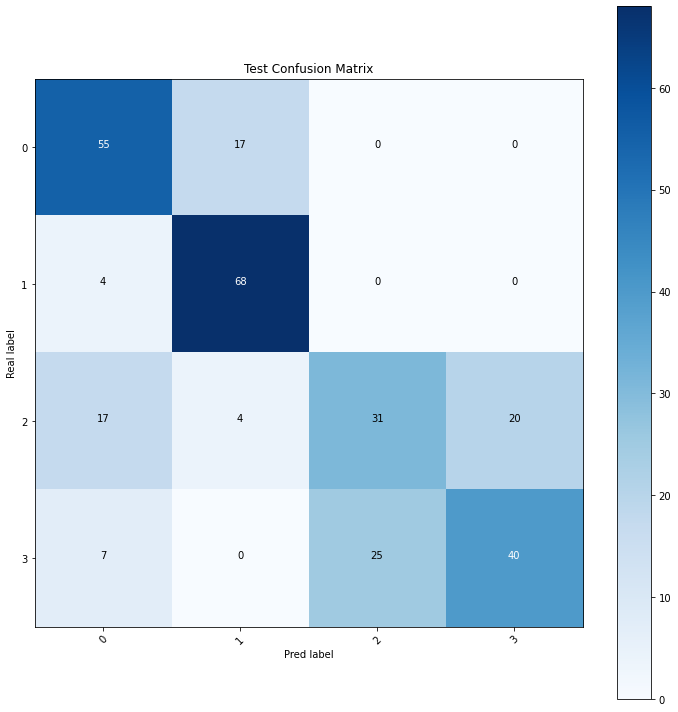

In [ ]:
# load model
ld_model = Model.load(history["lastest_model_path"])
eva_test = ld_model.evaluate(dataloader=testloader)
print(f"Test Accuracy: {eva_test[1]:.4f}\tTest Loss: {eva_test[0]:.4f}")
rec_test = {"total": [0, 0, 0, 0], "hit": [0, 0, 0, 0]}
conf_matrix_test = np.zeros(shape=(4, 4), dtype="uint8")

real_test = teY.reshape(teY.size)
pred_test = ld_model.predict(dataset=testset)
for i in range(real_test.size):
    rec_test["total"][real_test[i]] += 1
    rec_test["hit"][real_test[i]] += (1 if real_test[i] == pred_test[i] else 0)
    conf_matrix_test[real_test[i]][pred_test[i]] += 1
for i in range(4):
    print("Test accuracy of class-{}: {}".format(i, rec_test["hit"][i] / rec_test["total"][i]))
plot_confusion_matrix(conf_matrix_test, "Test Confusion Matrix")

## Problem 4

In [ ]:
""" use subject individual scheme """
train_raw = loadmat(DATASET_DIR + "BCIC_S01_T.mat")
test_raw = loadmat(DATASET_DIR + "BCIC_S01_E.mat")
trX, trY, teX, teY = train_raw["x_train"], train_raw["y_train"], test_raw["x_test"], test_raw["y_test"]
x_train = torch.from_numpy(np.expand_dims(trX, axis=1))
y_train = torch.from_numpy(np.reshape(trY, (trY.size, ))).long()
x_test = torch.from_numpy(np.expand_dims(teX, axis=1))
y_test = torch.from_numpy(np.reshape(teY, (teY.size, ))).long()
trainset, testset = TensorDataset(x_train, y_train), TensorDataset(x_test, y_test)
# use same test loader
testloader = DataLoader(dataset=testset, batch_size=128, shuffle=True)

### Shuffle=True

In [ ]:
# model with shuffle=True
trainloader = DataLoader(dataset=trainset, batch_size=128, shuffle=True)
model = Model(EEGNet().to(device), lr=0.001)
true_shuffle_his = model.fit(trainloader=trainloader, validloader=testloader, epochs=500, monitor=["acc", "val_acc"])
true_shuffle_ld_model = Model.load(true_shuffle_his["lastest_model_path"])

Epoch 1/500
3/3 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.2312s - loss: 1.4042 - acc: 0.2535 - val_loss: 1.3898 - val_acc: 0.2535
Epoch 10/500
3/3 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.1961s - loss: 1.3060 - acc: 0.4688 - val_loss: 1.3366 - val_acc: 0.3889
Epoch 20/500
3/3 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.1933s - loss: 1.0622 - acc: 0.5382 - val_loss: 1.1540 - val_acc: 0.4514
Epoch 30/500
3/3 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.1912s - loss: 1.1166 - acc: 0.5903 - val_loss: 0.9429 - val_acc: 0.5104
Epoch 40/500
3/3 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.1895s - loss: 0.8249 - acc: 0.6493 - val_loss: 0.8245 - val_acc: 0.5486
Epoch 50/500
3/3 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.1846s - loss: 0.6434 - acc: 0.6632 - val_loss: 0.8946 - val_acc: 0.5868
Epoch 60/500
3/3 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.1883s - loss: 0.6095 - acc: 0.6771 - val_loss: 0.8512 - val_acc: 0.6181
Epoch 70/500
3/3 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.1812s - loss: 0.5819 - acc: 0.7188 - val_loss: 0.9001 - val_acc: 0.6493
Epoch 80/

### Shuffle=False

In [ ]:
# model with shuffle=False
trainloader = DataLoader(dataset=trainset, batch_size=128, shuffle=False)
model = Model(EEGNet().to(device), lr=0.001)
false_shuffle_his = model.fit(trainloader=trainloader, validloader=testloader, epochs=500, monitor=["acc", "val_acc"])
false_shuffle_ld_model = Model.load(false_shuffle_his["lastest_model_path"])

Epoch 1/500
3/3 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.2049s - loss: 1.3913 - acc: 0.2431 - val_loss: 1.3816 - val_acc: 0.2465
Epoch 10/500
3/3 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.2009s - loss: 1.2968 - acc: 0.5347 - val_loss: 1.3155 - val_acc: 0.4479
Epoch 20/500
3/3 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.1958s - loss: 0.9179 - acc: 0.5903 - val_loss: 1.0034 - val_acc: 0.4931
Epoch 30/500
3/3 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.1892s - loss: 0.6298 - acc: 0.6424 - val_loss: 1.0628 - val_acc: 0.5833
Epoch 40/500
3/3 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.1947s - loss: 0.5282 - acc: 0.6979 - val_loss: 0.7609 - val_acc: 0.6076
Epoch 50/500
3/3 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.1897s - loss: 0.4635 - acc: 0.7118 - val_loss: 0.6679 - val_acc: 0.6354
Epoch 60/500
3/3 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.1917s - loss: 0.4044 - acc: 0.7431 - val_loss: 0.6846 - val_acc: 0.6458
Epoch 70/500
3/3 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.1908s - loss: 0.3639 - acc: 0.7500 - val_loss: 0.6598 - val_acc: 0.6736
Epoch 80/

In [ ]:
eva_true_shuffle = true_shuffle_ld_model.evaluate(testloader)
print(f"True Shuffle Train Accuracy: {eva_true_shuffle[1]:.4f}\tTrain Loss: {eva_true_shuffle[0]:.4f}")
eva_false_shuffle = false_shuffle_ld_model.evaluate(testloader)
print(f"False Shuffle Train Accuracy: {eva_false_shuffle[1]:.4f}\tTrain Loss: {eva_false_shuffle[0]:.4f}")

True Shuffle Train Accuracy: 0.7986	Train Loss: 0.7248
False Shuffle Train Accuracy: 0.7882	Train Loss: 0.3751


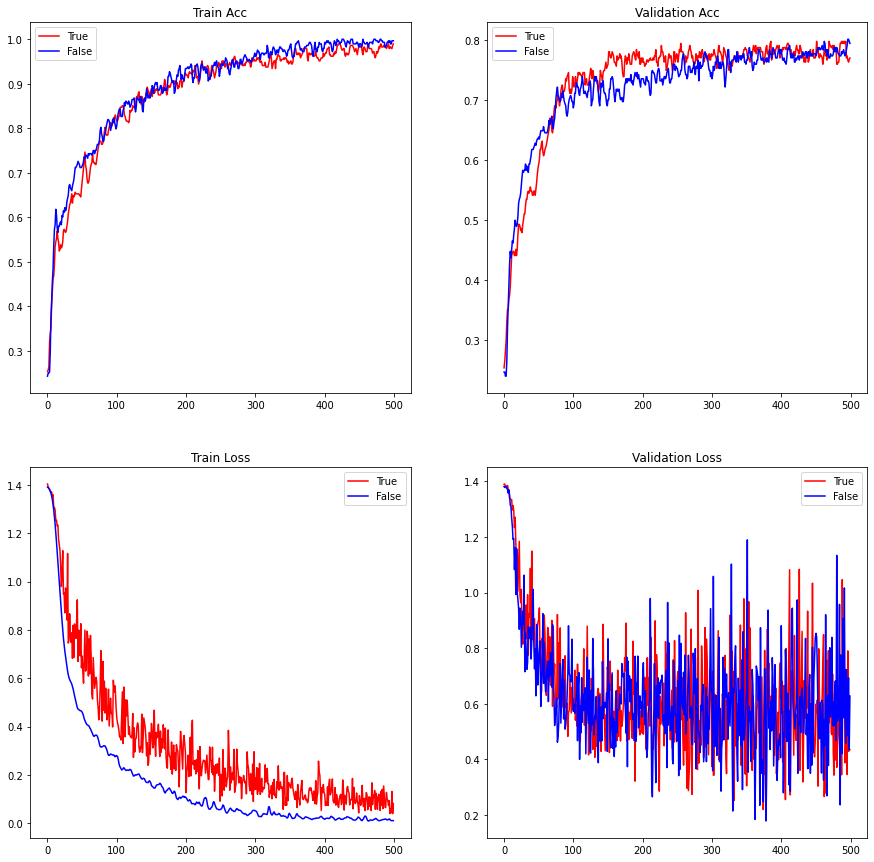

In [ ]:
plt.figure(figsize = (15, 15))
plt.subplot(2, 2, 1)
plt.title("Train Acc")
plt.plot(true_shuffle_his["acc"], color="red", label="True")
plt.plot(false_shuffle_his["acc"], color="blue", label="False")
plt.legend(loc = "best", fontsize=10)
plt.subplot(2, 2, 2)
plt.title("Validation Acc")
plt.plot(true_shuffle_his["val_acc"], color="red", label="True")
plt.plot(false_shuffle_his["val_acc"], color="blue", label="False")
plt.legend(loc = "best", fontsize=10)
plt.subplot(2, 2, 3)
plt.title("Train Loss")
plt.plot(true_shuffle_his["loss"], color="red", label="True")
plt.plot(false_shuffle_his["loss"], color="blue", label="False")
plt.legend(loc = "best", fontsize=10)
plt.subplot(2, 2, 4)
plt.title("Validation Loss")
plt.plot(true_shuffle_his["val_loss"], color="red", label="True")
plt.plot(false_shuffle_his["val_loss"], color="blue", label="False")
plt.legend(loc = "best", fontsize=10)
plt.show()

# Part 2

In [9]:
train_raw_set = [loadmat(DATASET_DIR + f"BCIC_S0{i}_T.mat") for i in range(1, 10)]
test_raw_set = [loadmat(DATASET_DIR + f"BCIC_S0{i}_E.mat") for i in range(1, 10)]
""" All schemes share same testset """
teX, teY = test_raw_set[0]["x_test"], test_raw_set[0]["y_test"]
x_test = torch.from_numpy(np.expand_dims(teX, axis=1))
y_test = torch.from_numpy(np.reshape(teY, (teY.size, ))).long()
testset = TensorDataset(x_test, y_test)
""" Create Subject-Individual (Ind) Dataset """
trX, trY = train_raw_set[0]["x_train"], train_raw_set[0]["y_train"]
x_train = torch.from_numpy(np.expand_dims(trX, axis=1))
y_train = torch.from_numpy(np.reshape(trY, (trY.size, ))).long()
ind_trainset = TensorDataset(x_train, y_train)

""" Create Subject-Independent (SI) Dataset """
trX, trY = np.empty((0, 22, 562)), np.empty((0, 1))
for i in range(1, 9):
    trX = np.vstack([trX, train_raw_set[i]["x_train"]])
    trX = np.vstack([trX, test_raw_set[i]["x_test"]])
    trY = np.vstack([trY, train_raw_set[i]["y_train"]])
    trY = np.vstack([trY, test_raw_set[i]["y_test"]])
x_train = torch.from_numpy(np.expand_dims(trX, axis=1))
y_train = torch.from_numpy(np.reshape(trY, (trY.size, ))).long()
si_trainset = TensorDataset(x_train, y_train)

""" Create Subject-Dependent (SD) Dataset """
trX, trY = np.empty((0, 22, 562)), np.empty((0, 1))
for i in range(1, 9):
    trX = np.vstack([trX, train_raw_set[i]["x_train"]])
    trX = np.vstack([trX, test_raw_set[i]["x_test"]])
    trY = np.vstack([trY, train_raw_set[i]["y_train"]])
    trY = np.vstack([trY, test_raw_set[i]["y_test"]])
trX = np.vstack([trX, train_raw_set[0]["x_train"]])
trY = np.vstack([trY, train_raw_set[0]["y_train"]])
x_train = torch.from_numpy(np.expand_dims(trX, axis=1))
y_train = torch.from_numpy(np.reshape(trY, (trY.size, ))).long()
sd_trainset = TensorDataset(x_train, y_train)

""" Create Subject-Independent + Fine-Tuning (SI+FT) Dataset """
# train by si_trainset
trX = train_raw_set[0]["x_train"]
trY = train_raw_set[0]["y_train"]
x_train = torch.from_numpy(np.expand_dims(trX, axis=1))
y_train = torch.from_numpy(np.reshape(trY, (trY.size, ))).long()
ft_trainset = TensorDataset(x_train, y_train)

## EEGNet

### Subject-Individual

Epoch 1/500
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.2180s - loss: 1.3743 - acc: 0.3403 - val_loss: 1.3819 - val_acc: 0.3090
Epoch 10/500
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.1989s - loss: 0.8957 - acc: 0.5903 - val_loss: 0.9109 - val_acc: 0.5382
Epoch 20/500
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.2111s - loss: 0.6755 - acc: 0.6701 - val_loss: 0.6946 - val_acc: 0.5868
Epoch 30/500
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.2113s - loss: 0.6266 - acc: 0.7014 - val_loss: 0.8542 - val_acc: 0.6250
Epoch 40/500
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.2072s - loss: 0.6363 - acc: 0.7535 - val_loss: 0.8096 - val_acc: 0.6701
Epoch 50/500
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.2016s - loss: 0.5275 - acc: 0.7986 - val_loss: 0.5012 - val_acc: 0.6875
Epoch 60/500
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.2133s - loss: 0.3779 - acc: 0.8264 - val_loss: 0.7153 - val_acc: 0.7153
Epoch 70/500
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.2125s - loss: 0.3285 - acc: 0.8438 - val_loss: 0.6587 - val_acc: 0.7188
Epoch 80/

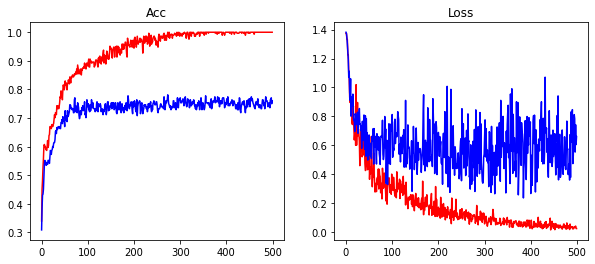

In [ ]:
trainloader = DataLoader(dataset=ind_trainset, batch_size=32, shuffle=True)
testloader = DataLoader(dataset=testset, batch_size=32, shuffle=True)
model = Model(EEGNet().to(device), lr=0.001)
eegnet_ind_his = model.fit(trainloader=trainloader, validloader=testloader, 
    epochs=500, monitor=["acc", "val_acc"])
plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
plt.title("Acc")
plt.plot(eegnet_ind_his["acc"], color="red")
plt.plot(eegnet_ind_his["val_acc"], color="blue")
plt.subplot(1, 2, 2)
plt.title("Loss")
plt.plot(eegnet_ind_his["loss"], color="red")
plt.plot(eegnet_ind_his["val_loss"], color="blue")
plt.show()

In [ ]:
ind_model = Model.load(eegnet_ind_his["lastest_model_path"])
eva_test = ind_model.evaluate(dataloader=testloader)
print(f"Test Accuracy: {eva_test[1]:.4f}\tTest Loss: {eva_test[0]:.4f}")
rec_test = {"total": [0, 0, 0, 0], "hit": [0, 0, 0, 0]}
real_test = teY.reshape(teY.size)
pred_test = ind_model.predict(dataset=testset)
for i in range(288):
    rec_test["total"][real_test[i]] += 1
    rec_test["hit"][real_test[i]] += (1 if real_test[i] == pred_test[i] else 0)
for i in range(4):
    print("Test accuracy of class-{}: {}".format(i, rec_test["hit"][i] / rec_test["total"][i]))

Test Accuracy: 0.7812	Test Loss: 0.7440
Test accuracy of class-0: 0.8888888888888888
Test accuracy of class-1: 0.9166666666666666
Test accuracy of class-2: 0.5972222222222222
Test accuracy of class-3: 0.7222222222222222


### Subject-Independent

Epoch 1/500
144/144 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1.2293s - loss: 1.3019 - acc: 0.3214 - val_loss: 1.3866 - val_acc: 0.3472
Epoch 10/500
144/144 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1.1518s - loss: 1.2162 - acc: 0.5265 - val_loss: 1.1353 - val_acc: 0.5069
Epoch 20/500
144/144 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1.1624s - loss: 1.0183 - acc: 0.5981 - val_loss: 0.8837 - val_acc: 0.6181
Epoch 30/500
144/144 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1.1620s - loss: 0.9746 - acc: 0.6124 - val_loss: 1.0427 - val_acc: 0.6181
Epoch 40/500
144/144 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1.1522s - loss: 1.1956 - acc: 0.6178 - val_loss: 1.0864 - val_acc: 0.5764
Epoch 50/500
144/144 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1.1383s - loss: 0.8664 - acc: 0.6361 - val_loss: 0.9095 - val_acc: 0.6458
Epoch 60/500
144/144 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1.1774s - loss: 0.8469 - acc: 0.6306 - val_loss: 0.8760 - val_acc: 0.5729
Epoch 70/500
144/144 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1.1691s - loss: 0.9734 - acc: 0.6439 - val_loss: 0.

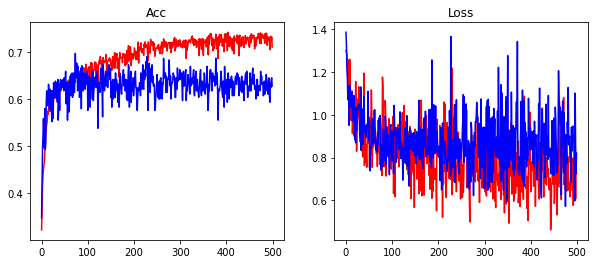

In [ ]:
trainloader = DataLoader(dataset=si_trainset, batch_size=32, shuffle=True)
testloader = DataLoader(dataset=testset, batch_size=32, shuffle=True)
model = Model(EEGNet().to(device), lr=0.001)
eegnet_si_his = model.fit(trainloader=trainloader, validloader=testloader, 
    epochs=500, monitor=["acc", "val_acc"])
plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
plt.title("Acc")
plt.plot(eegnet_si_his["acc"], color="red")
plt.plot(eegnet_si_his["val_acc"], color="blue")
plt.subplot(1, 2, 2)
plt.title("Loss")
plt.plot(eegnet_si_his["loss"], color="red")
plt.plot(eegnet_si_his["val_loss"], color="blue")
plt.show()

In [ ]:
si_model = Model.load(eegnet_si_his["lastest_model_path"])
eva_test = si_model.evaluate(dataloader=testloader)
print(f"Test Accuracy: {eva_test[1]:.4f}\tTest Loss: {eva_test[0]:.4f}")
rec_test = {"total": [0, 0, 0, 0], "hit": [0, 0, 0, 0]}
real_test = teY.reshape(teY.size)
pred_test = si_model.predict(dataset=testset)
for i in range(288):
    rec_test["total"][real_test[i]] += 1
    rec_test["hit"][real_test[i]] += (1 if real_test[i] == pred_test[i] else 0)
for i in range(4):
    print("Test accuracy of class-{}: {}".format(i, rec_test["hit"][i] / rec_test["total"][i]))

Test Accuracy: 0.6875	Test Loss: 0.6993
Test accuracy of class-0: 0.8888888888888888
Test accuracy of class-1: 0.8472222222222222
Test accuracy of class-2: 0.7916666666666666
Test accuracy of class-3: 0.2222222222222222


### Subject-Dependent

Epoch 1/500
153/153 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1.2292s - loss: 1.3750 - acc: 0.3335 - val_loss: 1.3385 - val_acc: 0.3750
Epoch 10/500
153/153 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1.2145s - loss: 1.0771 - acc: 0.5306 - val_loss: 0.9608 - val_acc: 0.6042
Epoch 20/500
153/153 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1.2122s - loss: 1.0651 - acc: 0.5915 - val_loss: 0.9310 - val_acc: 0.6354
Epoch 30/500
153/153 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1.2274s - loss: 0.9807 - acc: 0.6001 - val_loss: 0.9120 - val_acc: 0.6424
Epoch 40/500
153/153 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1.2173s - loss: 1.0691 - acc: 0.6277 - val_loss: 0.7199 - val_acc: 0.6736
Epoch 50/500
153/153 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1.2064s - loss: 0.7464 - acc: 0.6705 - val_loss: 0.7091 - val_acc: 0.6910
Epoch 60/500
153/153 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1.1934s - loss: 0.8064 - acc: 0.6699 - val_loss: 0.7735 - val_acc: 0.7188
Epoch 70/500
153/153 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1.2286s - loss: 0.8272 - acc: 0.6806 - val_loss: 0.

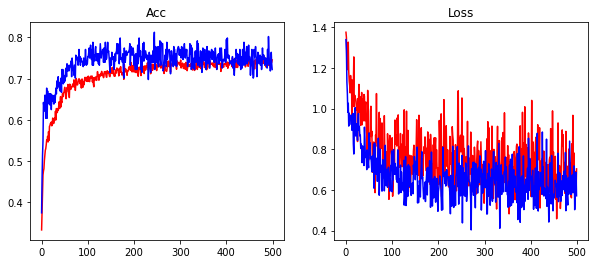

In [ ]:
trainloader = DataLoader(dataset=sd_trainset, batch_size=32, shuffle=True)
testloader = DataLoader(dataset=testset, batch_size=32, shuffle=True)
model = Model(EEGNet().to(device), lr=0.001)
eegnet_sd_his = model.fit(trainloader=trainloader, validloader=testloader, 
    epochs=500, monitor=["acc", "val_acc"])
plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
plt.title("Acc")
plt.plot(eegnet_sd_his["acc"], color="red")
plt.plot(eegnet_sd_his["val_acc"], color="blue")
plt.subplot(1, 2, 2)
plt.title("Loss")
plt.plot(eegnet_sd_his["loss"], color="red")
plt.plot(eegnet_sd_his["val_loss"], color="blue")
plt.show()

In [ ]:
sd_model = Model.load(eegnet_sd_his["lastest_model_path"])
eva_test = sd_model.evaluate(dataloader=testloader)
print(f"Test Accuracy: {eva_test[1]:.4f}\tTest Loss: {eva_test[0]:.4f}")
rec_test = {"total": [0, 0, 0, 0], "hit": [0, 0, 0, 0]}
real_test = teY.reshape(teY.size)
pred_test = sd_model.predict(dataset=testset)
for i in range(288):
    rec_test["total"][real_test[i]] += 1
    rec_test["hit"][real_test[i]] += (1 if real_test[i] == pred_test[i] else 0)
for i in range(4):
    print("Test accuracy of class-{}: {}".format(i, rec_test["hit"][i] / rec_test["total"][i]))

Test Accuracy: 0.8125	Test Loss: 0.5925
Test accuracy of class-0: 0.9305555555555556
Test accuracy of class-1: 0.9305555555555556
Test accuracy of class-2: 0.6944444444444444
Test accuracy of class-3: 0.6944444444444444


### Subject-Independent + Fine-Tuning

Epoch 1/500
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.1728s - loss: 1.2962 - acc: 0.5694 - val_loss: 1.2927 - val_acc: 0.5069
Epoch 10/500
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.1704s - loss: 0.9471 - acc: 0.7431 - val_loss: 1.0439 - val_acc: 0.6667
Epoch 20/500
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.1745s - loss: 0.7124 - acc: 0.7812 - val_loss: 0.8610 - val_acc: 0.7049
Epoch 30/500
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.1695s - loss: 0.6217 - acc: 0.8056 - val_loss: 0.9014 - val_acc: 0.6910
Epoch 40/500
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.1882s - loss: 0.6904 - acc: 0.8333 - val_loss: 0.6931 - val_acc: 0.7118
Epoch 50/500
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.1763s - loss: 0.7684 - acc: 0.8472 - val_loss: 0.7804 - val_acc: 0.7014
Epoch 60/500
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.1729s - loss: 0.5284 - acc: 0.8507 - val_loss: 0.7331 - val_acc: 0.6910
Epoch 70/500
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.1738s - loss: 0.4835 - acc: 0.8646 - val_loss: 0.6125 - val_acc: 0.6875
Epoch 80/

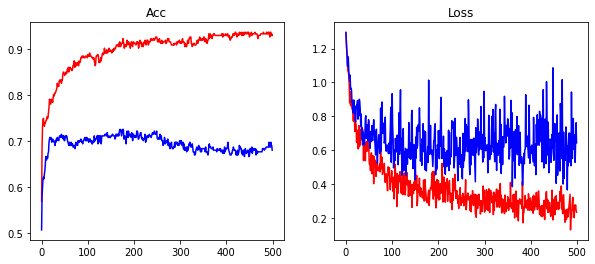

In [ ]:
trainloader = DataLoader(dataset=ft_trainset, batch_size=32, shuffle=True)
testloader = DataLoader(dataset=testset, batch_size=32, shuffle=True)
si_model.save("./model/pre-trained_si_model.pt")
si_model_dup = torch.load("./model/pre-trained_si_model.pt")
for param in si_model_dup.parameters():
    param.requires_grad = False
si_model_dup.classifier = nn.Linear(si_model_dup.classifier.in_features, 4)
ft_model = si_model_dup.to(device)
model = Model(ft_model, lr=0.001)
model.optimizer = optim.Adam(ft_model.classifier.parameters(), lr=0.001)
eegnet_sift_his = model.fit(trainloader=trainloader, validloader=testloader, epochs=500, monitor=["acc", "val_acc"])
plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
plt.title("Acc")
plt.plot(eegnet_sift_his["acc"], color="red")
plt.plot(eegnet_sift_his["val_acc"], color="blue")
plt.subplot(1, 2, 2)
plt.title("Loss")
plt.plot(eegnet_sift_his["loss"], color="red")
plt.plot(eegnet_sift_his["val_loss"], color="blue")
plt.show()

In [ ]:
sift_model = Model.load(eegnet_sift_his["lastest_model_path"])
eva_test = sift_model.evaluate(dataloader=testloader)
print(f"Test Accuracy: {eva_test[1]:.4f}\tTest Loss: {eva_test[0]:.4f}")
rec_test = {"total": [0, 0, 0, 0], "hit": [0, 0, 0, 0]}
real_test = teY.reshape(teY.size)
pred_test = sift_model.predict(dataset=testset)
for i in range(288):
    rec_test["total"][real_test[i]] += 1
    rec_test["hit"][real_test[i]] += (1 if real_test[i] == pred_test[i] else 0)
for i in range(4):
    print("Test accuracy of class-{}: {}".format(i, rec_test["hit"][i] / rec_test["total"][i]))

Test Accuracy: 0.7257	Test Loss: 0.6141
Test accuracy of class-0: 0.875
Test accuracy of class-1: 0.7777777777777778
Test accuracy of class-2: 0.9027777777777778
Test accuracy of class-3: 0.3472222222222222


## Shallow ConvNet

### Subject-Individual

Epoch 1/500
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.4171s - loss: 1.5258 - acc: 0.2986 - val_loss: 2.3425 - val_acc: 0.2951
Epoch 10/500
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.3608s - loss: 0.0539 - acc: 1.0000 - val_loss: 0.6069 - val_acc: 0.6181
Epoch 20/500
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.3659s - loss: 0.0158 - acc: 1.0000 - val_loss: 1.2092 - val_acc: 0.6319
Epoch 30/500
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.3733s - loss: 0.0118 - acc: 1.0000 - val_loss: 1.1523 - val_acc: 0.6493
Epoch 40/500
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.3686s - loss: 0.0050 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.6632
Epoch 50/500
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.3766s - loss: 0.0026 - acc: 1.0000 - val_loss: 0.9237 - val_acc: 0.6597
Epoch 60/500
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.3827s - loss: 0.0017 - acc: 1.0000 - val_loss: 0.9072 - val_acc: 0.6701
Epoch 70/500
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.3825s - loss: 0.0014 - acc: 1.0000 - val_loss: 1.3845 - val_acc: 0.6806
Epoch 80/

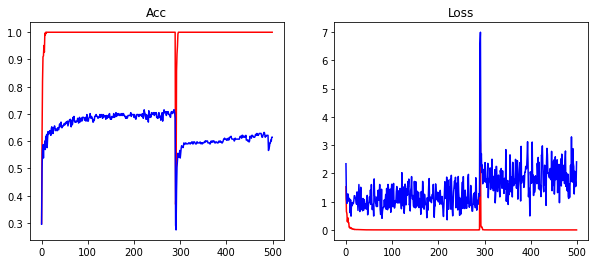

In [ ]:
trainloader = DataLoader(dataset=ind_trainset, batch_size=32, shuffle=True)
testloader = DataLoader(dataset=testset, batch_size=32, shuffle=True)
model = Model(ShallowConvNet().to(device), lr=0.001)
sha_convnet_ind_his = model.fit(trainloader=trainloader, validloader=testloader, 
    epochs=500, monitor=["acc", "val_acc"])
plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
plt.title("Acc")
plt.plot(sha_convnet_ind_his["acc"], color="red")
plt.plot(sha_convnet_ind_his["val_acc"], color="blue")
plt.subplot(1, 2, 2)
plt.title("Loss")
plt.plot(sha_convnet_ind_his["loss"], color="red")
plt.plot(sha_convnet_ind_his["val_loss"], color="blue")
plt.show()

In [ ]:
ind_model = Model.load(sha_convnet_ind_his["lastest_model_path"])
eva_test = ind_model.evaluate(dataloader=testloader)
print(f"Test Accuracy: {eva_test[1]:.4f}\tTest Loss: {eva_test[0]:.4f}")
rec_test = {"total": [0, 0, 0, 0], "hit": [0, 0, 0, 0]}
real_test = teY.reshape(teY.size)
pred_test = ind_model.predict(dataset=testset)
for i in range(288):
    rec_test["total"][real_test[i]] += 1
    rec_test["hit"][real_test[i]] += (1 if real_test[i] == pred_test[i] else 0)
for i in range(4):
    print("Test accuracy of class-{}: {}".format(i, rec_test["hit"][i] / rec_test["total"][i]))

Test Accuracy: 0.6181	Test Loss: 0.8931
Test accuracy of class-0: 0.5555555555555556
Test accuracy of class-1: 0.8888888888888888
Test accuracy of class-2: 0.5
Test accuracy of class-3: 0.5277777777777778


### Subject-Independent

Epoch 1/500
144/144 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 4.8316s - loss: 1.1086 - acc: 0.4130 - val_loss: 1.3031 - val_acc: 0.3785
Epoch 10/500
144/144 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 4.9153s - loss: 0.8657 - acc: 0.6786 - val_loss: 1.0151 - val_acc: 0.5590
Epoch 20/500
144/144 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 4.9215s - loss: 0.9101 - acc: 0.7231 - val_loss: 1.2050 - val_acc: 0.5694
Epoch 30/500
144/144 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 4.8726s - loss: 0.2934 - acc: 0.8468 - val_loss: 1.1928 - val_acc: 0.6146
Epoch 40/500
144/144 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 4.9600s - loss: 0.6260 - acc: 0.8579 - val_loss: 0.7638 - val_acc: 0.6285
Epoch 50/500
144/144 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 4.9276s - loss: 0.2753 - acc: 0.9191 - val_loss: 1.1210 - val_acc: 0.5833
Epoch 60/500
144/144 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 4.8981s - loss: 0.4406 - acc: 0.8516 - val_loss: 1.1551 - val_acc: 0.6181
Epoch 70/500
144/144 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 4.8862s - loss: 0.3210 - acc: 0.9169 - val_loss: 1.

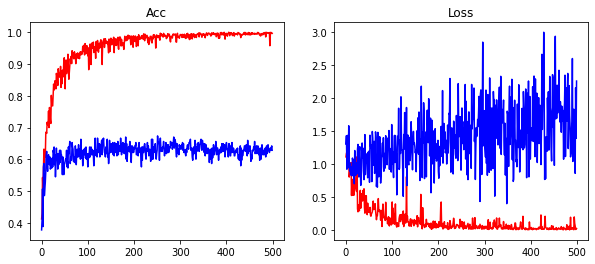

In [ ]:
trainloader = DataLoader(dataset=si_trainset, batch_size=32, shuffle=True)
testloader = DataLoader(dataset=testset, batch_size=32, shuffle=True)
model = Model(ShallowConvNet().to(device), lr=0.001)
sha_convnet_si_his = model.fit(trainloader=trainloader, validloader=testloader, 
    epochs=500, monitor=["acc", "val_acc"])
plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
plt.title("Acc")
plt.plot(sha_convnet_si_his["acc"], color="red")
plt.plot(sha_convnet_si_his["val_acc"], color="blue")
plt.subplot(1, 2, 2)
plt.title("Loss")
plt.plot(sha_convnet_si_his["loss"], color="red")
plt.plot(sha_convnet_si_his["val_loss"], color="blue")
plt.show()

In [ ]:
si_model = Model.load(sha_convnet_si_his["lastest_model_path"])
eva_test = si_model.evaluate(dataloader=testloader)
print(f"Test Accuracy: {eva_test[1]:.4f}\tTest Loss: {eva_test[0]:.4f}")
rec_test = {"total": [0, 0, 0, 0], "hit": [0, 0, 0, 0]}
real_test = teY.reshape(teY.size)
pred_test = si_model.predict(dataset=testset)
for i in range(288):
    rec_test["total"][real_test[i]] += 1
    rec_test["hit"][real_test[i]] += (1 if real_test[i] == pred_test[i] else 0)
for i in range(4):
    print("Test accuracy of class-{}: {}".format(i, rec_test["hit"][i] / rec_test["total"][i]))

Test Accuracy: 0.6736	Test Loss: 1.7305
Test accuracy of class-0: 0.8611111111111112
Test accuracy of class-1: 0.75
Test accuracy of class-2: 0.4027777777777778
Test accuracy of class-3: 0.6805555555555556


### Subject-Dependent

Epoch 1/500
153/153 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 8.5727s - loss: 1.1609 - acc: 0.4498 - val_loss: 1.2511 - val_acc: 0.5451
Epoch 10/500
153/153 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 8.4751s - loss: 1.0570 - acc: 0.6364 - val_loss: 1.0314 - val_acc: 0.5278
Epoch 20/500
153/153 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 8.5148s - loss: 0.6532 - acc: 0.7847 - val_loss: 1.1351 - val_acc: 0.6493
Epoch 30/500
153/153 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 8.4624s - loss: 0.4229 - acc: 0.7674 - val_loss: 0.6457 - val_acc: 0.6701
Epoch 40/500
153/153 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 8.4261s - loss: 0.3068 - acc: 0.8519 - val_loss: 0.9166 - val_acc: 0.7188
Epoch 50/500
153/153 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 8.4835s - loss: 0.7033 - acc: 0.8413 - val_loss: 0.6578 - val_acc: 0.6701
Epoch 60/500
153/153 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 8.4816s - loss: 0.1045 - acc: 0.9138 - val_loss: 0.4890 - val_acc: 0.6875
Epoch 70/500
153/153 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 8.4946s - loss: 0.1844 - acc: 0.9259 - val_loss: 1.

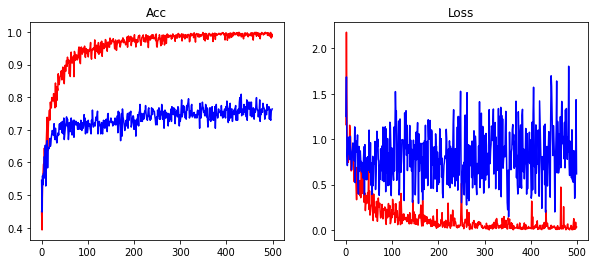

In [ ]:
trainloader = DataLoader(dataset=sd_trainset, batch_size=32, shuffle=True)
testloader = DataLoader(dataset=testset, batch_size=32, shuffle=True)
model = Model(ShallowConvNet().to(device), lr=0.001)
sha_convnet_sd_his = model.fit(trainloader=trainloader, validloader=testloader, 
    epochs=500, monitor=["acc", "val_acc"])
plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
plt.title("Acc")
plt.plot(sha_convnet_sd_his["acc"], color="red")
plt.plot(sha_convnet_sd_his["val_acc"], color="blue")
plt.subplot(1, 2, 2)
plt.title("Loss")
plt.plot(sha_convnet_sd_his["loss"], color="red")
plt.plot(sha_convnet_sd_his["val_loss"], color="blue")
plt.show()

In [ ]:
sd_model = Model.load(sha_convnet_sd_his["lastest_model_path"])
eva_test = sd_model.evaluate(dataloader=testloader)
print(f"Test Accuracy: {eva_test[1]:.4f}\tTest Loss: {eva_test[0]:.4f}")
rec_test = {"total": [0, 0, 0, 0], "hit": [0, 0, 0, 0]}
real_test = teY.reshape(teY.size)
pred_test = sd_model.predict(dataset=testset)
for i in range(288):
    rec_test["total"][real_test[i]] += 1
    rec_test["hit"][real_test[i]] += (1 if real_test[i] == pred_test[i] else 0)
for i in range(4):
    print("Test accuracy of class-{}: {}".format(i, rec_test["hit"][i] / rec_test["total"][i]))

Test Accuracy: 0.7917	Test Loss: 0.3245
Test accuracy of class-0: 0.9166666666666666
Test accuracy of class-1: 0.8055555555555556
Test accuracy of class-2: 0.75
Test accuracy of class-3: 0.6944444444444444


### Subject-Independent + Fine-Tuning

Epoch 1/500
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.1830s - loss: 0.9410 - acc: 0.6701 - val_loss: 1.0876 - val_acc: 0.5590
Epoch 10/500
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.1789s - loss: 0.2294 - acc: 1.0000 - val_loss: 0.6558 - val_acc: 0.7014
Epoch 20/500
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.1693s - loss: 0.0913 - acc: 1.0000 - val_loss: 0.5876 - val_acc: 0.7222
Epoch 30/500
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.1668s - loss: 0.0431 - acc: 1.0000 - val_loss: 0.6508 - val_acc: 0.7153
Epoch 40/500
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.1739s - loss: 0.0264 - acc: 1.0000 - val_loss: 0.6932 - val_acc: 0.7292
Epoch 50/500
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.1840s - loss: 0.0151 - acc: 1.0000 - val_loss: 0.5664 - val_acc: 0.7222
Epoch 60/500
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.1772s - loss: 0.0178 - acc: 1.0000 - val_loss: 0.7343 - val_acc: 0.7188
Epoch 70/500
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.1755s - loss: 0.0133 - acc: 1.0000 - val_loss: 0.6635 - val_acc: 0.7257
Epoch 80/

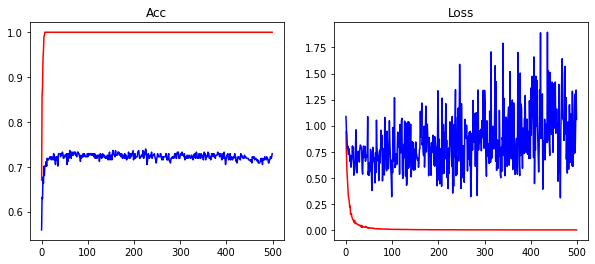

In [ ]:
trainloader = DataLoader(dataset=ft_trainset, batch_size=32, shuffle=True)
testloader = DataLoader(dataset=testset, batch_size=32, shuffle=True)
si_model.save("./model/pre-trained_si_model.pt")
si_model_dup = torch.load("./model/pre-trained_si_model.pt")
for param in si_model_dup.parameters():
    param.requires_grad = False
si_model_dup.classifier = nn.Linear(si_model_dup.classifier.in_features, 4)
ft_model = si_model_dup.to(device)
model = Model(ft_model, lr=0.001)
model.optimizer = optim.Adam(ft_model.classifier.parameters(), lr=0.001)
sha_convnet_sift_his = model.fit(trainloader=trainloader, validloader=testloader, epochs=500, monitor=["acc", "val_acc"])
plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
plt.title("Acc")
plt.plot(sha_convnet_sift_his["acc"], color="red")
plt.plot(sha_convnet_sift_his["val_acc"], color="blue")
plt.subplot(1, 2, 2)
plt.title("Loss")
plt.plot(sha_convnet_sift_his["loss"], color="red")
plt.plot(sha_convnet_sift_his["val_loss"], color="blue")
plt.show()

In [ ]:
sift_model = Model.load(sha_convnet_sift_his["lastest_model_path"])
eva_test = sift_model.evaluate(dataloader=testloader)
print(f"Test Accuracy: {eva_test[1]:.4f}\tTest Loss: {eva_test[0]:.4f}")
rec_test = {"total": [0, 0, 0, 0], "hit": [0, 0, 0, 0]}
real_test = teY.reshape(teY.size)
pred_test = sift_model.predict(dataset=testset)
for i in range(288):
    rec_test["total"][real_test[i]] += 1
    rec_test["hit"][real_test[i]] += (1 if real_test[i] == pred_test[i] else 0)
for i in range(4):
    print("Test accuracy of class-{}: {}".format(i, rec_test["hit"][i] / rec_test["total"][i]))

Test Accuracy: 0.7118	Test Loss: 0.6581
Test accuracy of class-0: 0.7638888888888888
Test accuracy of class-1: 0.8333333333333334
Test accuracy of class-2: 0.5138888888888888
Test accuracy of class-3: 0.7361111111111112


## SCCNet

### Subject-Individual

Epoch 1/500
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.5040s - loss: 1.1741 - acc: 0.3889 - val_loss: 1.5634 - val_acc: 0.3438
Epoch 10/500
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.1886s - loss: 0.2421 - acc: 0.9549 - val_loss: 0.8522 - val_acc: 0.7188
Epoch 20/500
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.1940s - loss: 0.0875 - acc: 0.9965 - val_loss: 0.6044 - val_acc: 0.7153
Epoch 30/500
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.1830s - loss: 0.0493 - acc: 1.0000 - val_loss: 0.5577 - val_acc: 0.7431
Epoch 40/500
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.1895s - loss: 0.0244 - acc: 1.0000 - val_loss: 0.6957 - val_acc: 0.7465
Epoch 50/500
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.1857s - loss: 0.0144 - acc: 1.0000 - val_loss: 0.5154 - val_acc: 0.7465
Epoch 60/500
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.1837s - loss: 0.0098 - acc: 1.0000 - val_loss: 0.3366 - val_acc: 0.7639
Epoch 70/500
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.1794s - loss: 0.0065 - acc: 1.0000 - val_loss: 0.8026 - val_acc: 0.7708
Epoch 80/

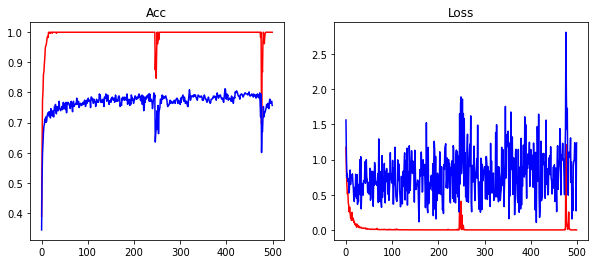

In [10]:
trainloader = DataLoader(dataset=ind_trainset, batch_size=32, shuffle=True)
testloader = DataLoader(dataset=testset, batch_size=32, shuffle=True)
model = Model(SCCNet().to(device), lr=0.001)
sccnet_ind_his = model.fit(trainloader=trainloader, validloader=testloader, 
    epochs=500, monitor=["acc", "val_acc"])
plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
plt.title("Acc")
plt.plot(sccnet_ind_his["acc"], color="red")
plt.plot(sccnet_ind_his["val_acc"], color="blue")
plt.subplot(1, 2, 2)
plt.title("Loss")
plt.plot(sccnet_ind_his["loss"], color="red")
plt.plot(sccnet_ind_his["val_loss"], color="blue")
plt.show()

In [11]:
ind_model = Model.load(sccnet_ind_his["lastest_model_path"])
eva_test = ind_model.evaluate(dataloader=testloader)
print(f"Test Accuracy: {eva_test[1]:.4f}\tTest Loss: {eva_test[0]:.4f}")
rec_test = {"total": [0, 0, 0, 0], "hit": [0, 0, 0, 0]}
real_test = teY.reshape(teY.size)
pred_test = ind_model.predict(dataset=testset)
for i in range(288):
    rec_test["total"][real_test[i]] += 1
    rec_test["hit"][real_test[i]] += (1 if real_test[i] == pred_test[i] else 0)
for i in range(4):
    print("Test accuracy of class-{}: {}".format(i, rec_test["hit"][i] / rec_test["total"][i]))

Test Accuracy: 0.7465	Test Loss: 0.7014
Test accuracy of class-0: 0.9583333333333334
Test accuracy of class-1: 0.875
Test accuracy of class-2: 0.4305555555555556
Test accuracy of class-3: 0.7222222222222222


### Subject-Independent

Epoch 1/500
144/144 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.9966s - loss: 1.3896 - acc: 0.4312 - val_loss: 1.3529 - val_acc: 0.2743
Epoch 10/500
144/144 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.9791s - loss: 0.5822 - acc: 0.7072 - val_loss: 0.9000 - val_acc: 0.6562
Epoch 20/500
144/144 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.9915s - loss: 0.5353 - acc: 0.7756 - val_loss: 0.5700 - val_acc: 0.6806
Epoch 30/500
144/144 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.9703s - loss: 0.4223 - acc: 0.8227 - val_loss: 0.6424 - val_acc: 0.7361
Epoch 40/500
144/144 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.9820s - loss: 0.4738 - acc: 0.8535 - val_loss: 1.1025 - val_acc: 0.7049
Epoch 50/500
144/144 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.9608s - loss: 0.5184 - acc: 0.8535 - val_loss: 0.8174 - val_acc: 0.7257
Epoch 60/500
144/144 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.9631s - loss: 0.3349 - acc: 0.8375 - val_loss: 0.8069 - val_acc: 0.6493
Epoch 70/500
144/144 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.9732s - loss: 0.3420 - acc: 0.8535 - val_loss: 0.

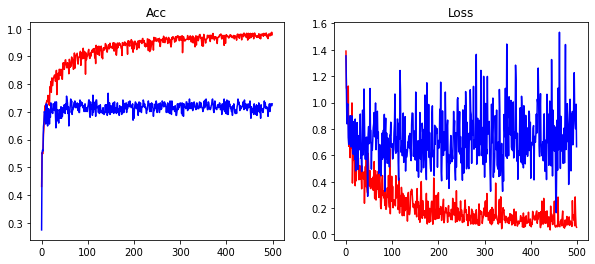

In [12]:
trainloader = DataLoader(dataset=si_trainset, batch_size=32, shuffle=True)
testloader = DataLoader(dataset=testset, batch_size=32, shuffle=True)
model = Model(SCCNet().to(device), lr=0.001)
sccnet_si_his = model.fit(trainloader=trainloader, validloader=testloader, 
    epochs=500, monitor=["acc", "val_acc"])
plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
plt.title("Acc")
plt.plot(sccnet_si_his["acc"], color="red")
plt.plot(sccnet_si_his["val_acc"], color="blue")
plt.subplot(1, 2, 2)
plt.title("Loss")
plt.plot(sccnet_si_his["loss"], color="red")
plt.plot(sccnet_si_his["val_loss"], color="blue")
plt.show()

In [13]:
si_model = Model.load(sccnet_si_his["lastest_model_path"])
eva_test = si_model.evaluate(dataloader=testloader)
print(f"Test Accuracy: {eva_test[1]:.4f}\tTest Loss: {eva_test[0]:.4f}")
rec_test = {"total": [0, 0, 0, 0], "hit": [0, 0, 0, 0]}
real_test = teY.reshape(teY.size)
pred_test = si_model.predict(dataset=testset)
for i in range(288):
    rec_test["total"][real_test[i]] += 1
    rec_test["hit"][real_test[i]] += (1 if real_test[i] == pred_test[i] else 0)
for i in range(4):
    print("Test accuracy of class-{}: {}".format(i, rec_test["hit"][i] / rec_test["total"][i]))

Test Accuracy: 0.7674	Test Loss: 0.5666
Test accuracy of class-0: 0.8888888888888888
Test accuracy of class-1: 0.9027777777777778
Test accuracy of class-2: 0.7361111111111112
Test accuracy of class-3: 0.5416666666666666


### Subject-Dependent

Epoch 1/500
153/153 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1.0780s - loss: 1.2603 - acc: 0.4706 - val_loss: 0.9765 - val_acc: 0.6076
Epoch 10/500
153/153 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1.0828s - loss: 0.5842 - acc: 0.7157 - val_loss: 0.6590 - val_acc: 0.7569
Epoch 20/500
153/153 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1.0512s - loss: 0.4263 - acc: 0.7945 - val_loss: 0.5798 - val_acc: 0.8333
Epoch 30/500
153/153 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1.0357s - loss: 0.3658 - acc: 0.8309 - val_loss: 0.3577 - val_acc: 0.8264
Epoch 40/500
153/153 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1.0506s - loss: 0.6125 - acc: 0.8476 - val_loss: 0.3034 - val_acc: 0.8125
Epoch 50/500
153/153 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1.0409s - loss: 0.5142 - acc: 0.8468 - val_loss: 0.5901 - val_acc: 0.8299
Epoch 60/500
153/153 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1.0803s - loss: 0.1365 - acc: 0.8932 - val_loss: 0.3542 - val_acc: 0.8368
Epoch 70/500
153/153 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1.0462s - loss: 0.3742 - acc: 0.8795 - val_loss: 0.

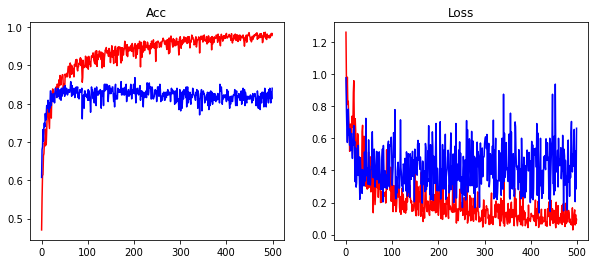

In [14]:
trainloader = DataLoader(dataset=sd_trainset, batch_size=32, shuffle=True)
testloader = DataLoader(dataset=testset, batch_size=32, shuffle=True)
model = Model(SCCNet().to(device), lr=0.001)
sccnet_sd_his = model.fit(trainloader=trainloader, validloader=testloader, 
    epochs=500, monitor=["acc", "val_acc"])
plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
plt.title("Acc")
plt.plot(sccnet_sd_his["acc"], color="red")
plt.plot(sccnet_sd_his["val_acc"], color="blue")
plt.subplot(1, 2, 2)
plt.title("Loss")
plt.plot(sccnet_sd_his["loss"], color="red")
plt.plot(sccnet_sd_his["val_loss"], color="blue")
plt.show()

In [16]:
sd_model = Model.load(sccnet_sd_his["lastest_model_path"])
eva_test = sd_model.evaluate(dataloader=testloader)
print(f"Test Accuracy: {eva_test[1]:.4f}\tTest Loss: {eva_test[0]:.4f}")
rec_test = {"total": [0, 0, 0, 0], "hit": [0, 0, 0, 0]}
real_test = teY.reshape(teY.size)
pred_test = sd_model.predict(dataset=testset)
for i in range(288):
    rec_test["total"][real_test[i]] += 1
    rec_test["hit"][real_test[i]] += (1 if real_test[i] == pred_test[i] else 0)
for i in range(4):
    print("Test accuracy of class-{}: {}".format(i, rec_test["hit"][i] / rec_test["total"][i]))

Test Accuracy: 0.8681	Test Loss: 0.1918
Test accuracy of class-0: 1.0
Test accuracy of class-1: 0.9444444444444444
Test accuracy of class-2: 0.7916666666666666
Test accuracy of class-3: 0.7361111111111112


### Subject-Independent + Fine-Tuning

Epoch 1/500
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.1828s - loss: 0.8450 - acc: 0.6528 - val_loss: 1.1470 - val_acc: 0.6146
Epoch 10/500
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.1804s - loss: 0.3401 - acc: 0.9375 - val_loss: 0.8121 - val_acc: 0.7431
Epoch 20/500
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.1754s - loss: 0.2071 - acc: 0.9722 - val_loss: 0.5803 - val_acc: 0.7674
Epoch 30/500
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.1759s - loss: 0.1517 - acc: 0.9826 - val_loss: 0.2862 - val_acc: 0.7743
Epoch 40/500
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.1749s - loss: 0.1347 - acc: 0.9896 - val_loss: 0.6468 - val_acc: 0.7812
Epoch 50/500
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.1702s - loss: 0.1174 - acc: 0.9931 - val_loss: 0.3743 - val_acc: 0.7951
Epoch 60/500
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.1789s - loss: 0.0894 - acc: 1.0000 - val_loss: 0.4417 - val_acc: 0.7917
Epoch 70/500
9/9 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 0.1786s - loss: 0.0633 - acc: 0.9965 - val_loss: 0.6001 - val_acc: 0.7812
Epoch 80/

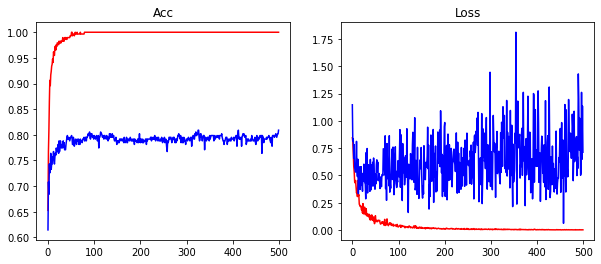

In [17]:
trainloader = DataLoader(dataset=ft_trainset, batch_size=32, shuffle=True)
testloader = DataLoader(dataset=testset, batch_size=32, shuffle=True)
si_model.save("./model/pre-trained_si_model.pt")
si_model_dup = torch.load("./model/pre-trained_si_model.pt")
for param in si_model_dup.parameters():
    param.requires_grad = False
si_model_dup.classifier = nn.Linear(si_model_dup.classifier.in_features, 4)
ft_model = si_model_dup.to(device)
model = Model(ft_model, lr=0.001)
model.optimizer = optim.Adam(ft_model.classifier.parameters(), lr=0.001)
sccnet_sift_his = model.fit(trainloader=trainloader, validloader=testloader, epochs=500, monitor=["acc", "val_acc"])
plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
plt.title("Acc")
plt.plot(sccnet_sift_his["acc"], color="red")
plt.plot(sccnet_sift_his["val_acc"], color="blue")
plt.subplot(1, 2, 2)
plt.title("Loss")
plt.plot(sccnet_sift_his["loss"], color="red")
plt.plot(sccnet_sift_his["val_loss"], color="blue")
plt.show()

In [19]:
sift_model = Model.load(sccnet_sift_his["lastest_model_path"])
eva_test = sift_model.evaluate(dataloader=testloader)
print(f"Test Accuracy: {eva_test[1]:.4f}\tTest Loss: {eva_test[0]:.4f}")
rec_test = {"total": [0, 0, 0, 0], "hit": [0, 0, 0, 0]}
real_test = teY.reshape(teY.size)
pred_test = sift_model.predict(dataset=testset)
for i in range(288):
    rec_test["total"][real_test[i]] += 1
    rec_test["hit"][real_test[i]] += (1 if real_test[i] == pred_test[i] else 0)
for i in range(4):
    print("Test accuracy of class-{}: {}".format(i, rec_test["hit"][i] / rec_test["total"][i]))

Test Accuracy: 0.8021	Test Loss: 0.7016
Test accuracy of class-0: 0.9305555555555556
Test accuracy of class-1: 0.9305555555555556
Test accuracy of class-2: 0.5138888888888888
Test accuracy of class-3: 0.8333333333333334
